In [3]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as pyoff

import warnings
warnings.filterwarnings("ignore")


pyoff.init_notebook_mode(connected=True)
#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [2]:
!pip install chart-studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.9 MB/s eta 0:00:00


In [4]:
df= pd.read_csv('/kaggle/input/combine-dataset-2009-2011/combine_dataset_2009_2011.csv')

df = df.drop(["Invoice","Description","Year","Customer ID","Country"],axis=1)
df.head(10)

,StockCode,Quantity,InvoiceDate,Price
0,85048,12,2009-12-01 07:45:00,6.95
1,22041,48,2009-12-01 07:45:00,2.10
2,21232,24,2009-12-01 07:45:00,1.25
3,22064,24,2009-12-01 07:45:00,1.65
4,21871,24,2009-12-01 07:45:00,1.25
5,21523,10,2009-12-01 07:45:00,5.95
6,22350,12,2009-12-01 07:46:00,2.55
7,22349,12,2009-12-01 07:46:00,3.75
8,22195,24,2009-12-01 07:46:00,1.65
9,22353,12,2009-12-01 07:46:00,2.55


In [5]:
df['total_price'] = df['Quantity']*df['Price']
df

,StockCode,Quantity,InvoiceDate,Price,total_price
0,85048,12,2009-12-01 07:45:00,6.95,83.40
1,22041,48,2009-12-01 07:45:00,2.10,100.80
2,21232,24,2009-12-01 07:45:00,1.25,30.00
3,22064,24,2009-12-01 07:45:00,1.65,39.60
4,21871,24,2009-12-01 07:45:00,1.25,30.00
...,...,...,...,...,...
932380,22613,12,2011-12-09 12:50:00,0.85,10.20
932381,22899,6,2011-12-09 12:50:00,2.10,12.60
932382,23254,4,2011-12-09 12:50:00,4.15,16.60
932383,23255,4,2011-12-09 12:50:00,4.15,16.60


In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = df['InvoiceDate'].dt.year.astype('str') + '-' + df['InvoiceDate'].dt.month.astype('str') + '-01'
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
#groupby date and sum the sales
df = df.groupby('InvoiceDate').total_price.sum().reset_index()

In [7]:
df

,InvoiceDate,total_price
0,2009-12-01,585913.55
1,2010-01-01,465013.56
2,2010-02-01,431156.98
3,2010-03-01,618384.01
4,2010-04-01,537679.24
5,2010-05-01,519658.51
6,2010-06-01,559982.25
7,2010-07-01,529572.65
8,2010-08-01,571107.55
9,2010-09-01,742555.89


In [9]:
plot_data = [
    go.Scatter(
        x=df['InvoiceDate'],
        y=df['total_price'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [10]:
#create a new dataframe to model the difference
df_diff = df.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df['total_price'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['total_price'] - df_diff['prev_sales'])
df_diff.head(10)

,InvoiceDate,total_price,prev_sales,diff
1,2010-01-01,465013.56,585913.55,-120899.99
2,2010-02-01,431156.98,465013.56,-33856.58
3,2010-03-01,618384.01,431156.98,187227.03
4,2010-04-01,537679.24,618384.01,-80704.77
5,2010-05-01,519658.51,537679.24,-18020.73
6,2010-06-01,559982.25,519658.51,40323.74
7,2010-07-01,529572.65,559982.25,-30409.60
8,2010-08-01,571107.55,529572.65,41534.90
9,2010-09-01,742555.89,571107.55,171448.34
10,2010-10-01,948514.30,742555.89,205958.41


In [12]:
#plot sales diff
plot_data = [
    go.Scatter(
        x=df_diff['InvoiceDate'],
        y=df_diff['diff'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [13]:
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [14]:
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

-0.053237949776930416


In [16]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['total_price','InvoiceDate'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values


In [17]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [18]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [22]:
model = Sequential()
model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2]), stateful=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False) 

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7342
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7187 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7084 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6991 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6902 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6818 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6736 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6658 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6583 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6510 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6439 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6371 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6305 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6240 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6178 
Epoch 16/100
6/6 ━━━

In [23]:
y_pred = model.predict(X_test,batch_size=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [24]:
y_pred

array([[-0.12401891],
       [-0.27216005],
       [-0.44384983],
       [ 0.1822046 ],
       [ 0.7685348 ],
       [ 0.59703636]], dtype=float32)

In [25]:
y_test

array([[ 0.24808426],
       [ 0.48310305],
       [ 1.20024565],
       [ 0.52930174],
       [ 1.3018057 ],
       [-2.01238267]])

In [27]:
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[-0.12401891  0.41212714  0.80838734 -0.15437138  0.65901925  0.14994444
  -2.13782326 -2.16627862  1.87189658  1.27372314  0.88221861 -0.08753145
  -0.41264229]]
[[-0.27216005  0.24808426  0.27683642  0.80838734 -0.15437138  0.65901925
  -0.33366205 -3.96761136 -2.6747158   2.0910379   1.139822    0.88221861
   0.0543372 ]]
[[-0.44384983  0.48310305  0.12850989  0.27683642  0.80838734 -0.15437138
   0.46503134 -1.11137282 -5.26133646 -2.17095086  1.90900453  1.139822
   0.89758321]]
[[ 0.1822046   1.20024565  0.34101238  0.12850989  0.27683642  0.80838734
  -0.81110669  0.15307008 -1.15992562 -4.59564584 -2.10199275  1.90900453
   1.1215822 ]]
[[ 0.76853478  0.52930174  0.98944818  0.34101238  0.12850989  0.27683642
   0.69937666 -1.86723419  0.65574902 -0.75098844 -4.38389575 -2.10199275
   1.79042474]]
[[ 0.59703636  1.3018057   0.38278495  0.98944818  0.34101238  0.12850989
  -0.13457975  0.52407138 -2.24530346  0.95102269 -0.7656529  -4.38389575
  -1.69733729]]


In [29]:
result_list = []
sales_dates = list(df[-7:].InvoiceDate)
act_sales = list(df[-7:].total_price)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['InvoiceDate'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [30]:
df_result

,pred_value,InvoiceDate
0,465775,2011-07-01
1,350968,2011-08-01
2,316760,2011-09-01
3,859925,2011-10-01
4,1132230,2011-11-01
5,1410129,2011-12-01


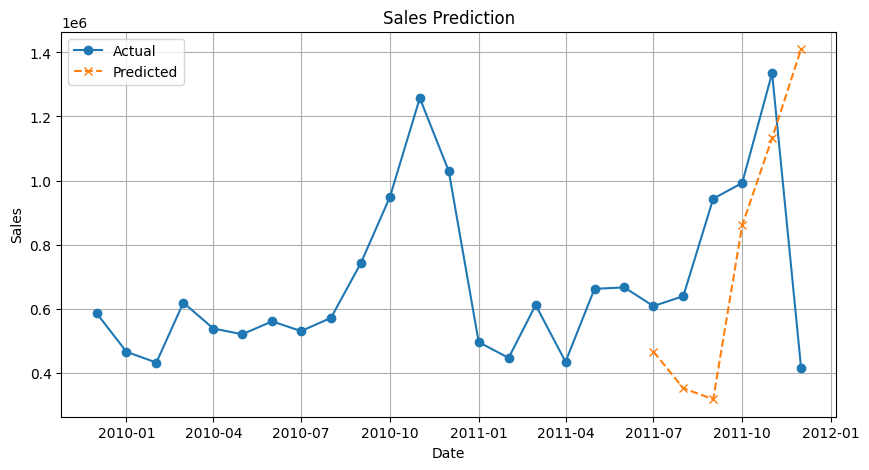

In [32]:
# Merge actual sales with predictions
df_sales_pred = pd.merge(df, df_result, on='InvoiceDate', how='left')

# Plot actual vs predicted sales
plt.figure(figsize=(10, 5))
plt.plot(df_sales_pred['InvoiceDate'], df_sales_pred['total_price'], label='Actual', marker='o')
plt.plot(df_sales_pred['InvoiceDate'], df_sales_pred['pred_value'], label='Predicted', linestyle='dashed', marker='x')

# Formatting
plt.title('Sales Prediction')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)

# Show plot
plt.show()